# WGAN-GP - Wasserstein GAN



## Importing the libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os
import time
from IPython import display
from tensorflow import keras
from tensorflow.keras import layers
tf.__version__

'2.12.0'

## Loading and preprocessing the dataset

In [ ]:
(X_train, y_train), (_, _) = tf.keras.datasets.mnist.load_data()

In [ ]:
X_train.shape, y_train.shape

((60000, 28, 28), (60000,))

In [ ]:
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')

In [ ]:
X_train.shape

(60000, 28, 28, 1)

In [ ]:
X_train = (X_train - 127.5) / 127.5

In [ ]:
buffer_size = 60000
batch_size = 256

In [ ]:
X_train = tf.data.Dataset.from_tensor_slices(X_train).shuffle(buffer_size).batch(batch_size)

## Building the generator

- The same architecture of DCGAN

In [ ]:
def build_generator():
  network = tf.keras.Sequential()

  network.add(layers.Dense(units = 7*7*256, use_bias = False, input_shape=(100,)))
  network.add(layers.BatchNormalization())
  network.add(layers.LeakyReLU())

  network.add(layers.Reshape((7,7,256)))

  # 7x7x128
  network.add(layers.Conv2DTranspose(filters = 128, kernel_size = (5,5), padding = 'same', use_bias = False))
  network.add(layers.BatchNormalization())
  network.add(layers.LeakyReLU())

  # 14x14x64
  network.add(layers.Conv2DTranspose(filters = 64, kernel_size = (5,5), padding = 'same', strides = (2,2), use_bias = False))
  network.add(layers.BatchNormalization())
  network.add(layers.LeakyReLU())

  # 28x28x1
  network.add(layers.Conv2DTranspose(filters = 1, kernel_size = (5,5), padding = 'same', strides = (2,2), use_bias=True, activation='tanh'))

  network.summary()

  return network

In [ ]:
generator = build_generator()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1254400   
                                                                 
 batch_normalization (BatchN  (None, 12544)            50176     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 7, 7, 128)        819200    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 7, 7, 128)        5

In [ ]:
noise = tf.random.normal([1, 100])
noise

<tf.Tensor: shape=(1, 100), dtype=float32, numpy=
array([[ 2.2037294 , -0.42967808,  0.38542458, -0.8093665 ,  0.54730123,
        -1.0566478 , -0.3691524 ,  1.8918731 ,  2.8190372 , -1.0066148 ,
        -0.770173  ,  0.05871979,  1.1307609 , -0.32731053, -0.8799195 ,
         0.08196256,  0.29203215,  0.7203387 , -1.0978489 , -0.34692776,
         0.34750006,  0.3692122 , -0.2371446 , -0.19174829,  0.6729161 ,
        -0.2973796 ,  1.1037207 ,  0.77354074,  1.1788483 ,  0.04253987,
         0.14234269,  0.14643182, -0.7802673 , -1.0664806 ,  1.2084713 ,
         1.8302971 ,  1.6616478 , -1.414312  ,  0.14925757, -1.3253998 ,
         0.11656824,  0.30473337,  1.1399871 ,  0.5641847 , -1.1194401 ,
         1.7506685 ,  0.51069415, -0.23982047, -0.812562  , -1.2967179 ,
        -0.30758202, -1.0414144 , -0.1463792 , -0.41508034, -0.45953998,
        -1.0907762 ,  0.63292456,  1.290971  , -0.53660923, -0.19146834,
        -1.1339226 ,  0.89284384,  1.1015298 ,  0.24741402,  0.9433887 ,
 

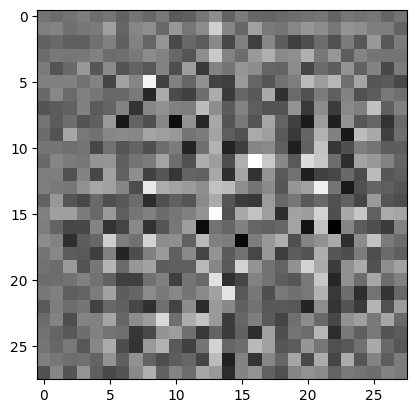

In [ ]:
generated_image = generator(noise, training = False)
plt.imshow(generated_image[0, :,:,0], cmap='gray');

## Building the discriminator

- The discriminator is also called as "critic"

In [ ]:
def build_discriminator():
  network = tf.keras.Sequential()

  # 14x14x64
  network.add(layers.Conv2D(filters = 64, strides = (2,2), kernel_size = (5,5), padding = 'same', input_shape = [28,28,1]))
  network.add(layers.LeakyReLU())
  network.add(layers.Dropout(0.3))

  # 7x7x128
  network.add(layers.Conv2D(filters = 128, strides = (2,2), kernel_size = (5,5), padding = 'same'))
  network.add(layers.LeakyReLU())
  network.add(layers.Dropout(0.3))

  network.add(layers.Flatten())
  network.add(layers.Dense(1))

  network.summary()

  return network

In [ ]:
discriminator = build_discriminator()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)             

In [ ]:
discriminator(generated_image, training = False) # logits

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00030457]], dtype=float32)>

In [ ]:
tf.sigmoid(-0.00030457)

<tf.Tensor: shape=(), dtype=float32, numpy=0.49992383>


## Function to calculate **Wasserstein Loss**

The (*loss*) is the difference between the expected output of the discriminator for authentic images and the expected output of the discriminator for fake images (generated by the generator).

* The objective of the discriminator is to maximize this difference, while the objective of the generator is to minimize it.


In [ ]:
(0.2 + 0.9 + 0.99) / 3

0.6966666666666667

In [ ]:
-1 * tf.math.reduce_mean([0.2, 0.9, 0.99])

<tf.Tensor: shape=(), dtype=float32, numpy=-0.6966667>

In [ ]:
def loss_generator(fake_output):
  g_loss = -1. * tf.math.reduce_mean(fake_output)
  return g_loss

In [ ]:
def loss_discriminator(real_output, fake_output, gradient_penalty):
  c_lambda = 10
  d_loss = tf.math.reduce_mean(fake_output) - tf.math.reduce_mean(real_output) + c_lambda * gradient_penalty
  return d_loss

## **Gradient Penalty**

- Beta parameters: https://stats.stackexchange.com/questions/265400/deep-learning-how-does-beta-1-and-beta-2-in-the-adam-optimizer-affect-its-lear#:~:text=The%20hyper%2Dparameters%20%CE%B21,each%20training%20step%20(batch).

 To use Wasserstein loss, the discriminator must be **1-L** [(1-Lipschitz) continous](https://www.coursera.org/lecture/build-basic-generative-adversarial-networks-gans/1-lipschitz-continuity-enforcement-GMPCt) - maximum 1.

To use 1-L we need **Gradient Penalty**.

This variation is called **WGAN-GP** (**G**radient **P**enalty)

(More information about Gradient Penalty [this article](https://towardsdatascience.com/demystified-wasserstein-gan-with-gradient-penalty-ba5e9b905ead))

Steps to calculate gradient penalty:
1. Calculate an interpolated image from the real and fake image (`(real_image * epsilon + fake_image * (1 — epsilon))`)
2. Calculate the gradient of the discriminator output relative to the interpolated image. After, we calculate the gradient norm. Documentation: - tf.norm: https://www.tensorflow.org/api_docs/python/tf/norm
3. Finally, the penalty is calculated as an average of the square of (norm - 1), as we want the norm to be close to one.

We use [GradientTape()](https://www.tensorflow.org/api_docs/python/tf/GradientTape)


In [ ]:
3 ** 2

9

In [ ]:
@tf.function
def gradient_penalty(real, fake, epsilon):
  interpolated_images = real * epsilon + fake * (1 - epsilon)
  with tf.GradientTape() as tape:
    tape.watch(interpolated_images)
    scores = discriminator(interpolated_images)[0]
  gradient = tape.gradient(scores, interpolated_images)[0]
  gradient_norm = tf.norm(gradient)
  gp = tf.math.reduce_mean((gradient_norm - 1)**2)
  return gp

In [ ]:
# 0.2 -> 0.02 -> 0.002

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0002, beta_1 = 0.5, beta_2 = 0.9)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0002, beta_1 = 0.5, beta_2 = 0.9)

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'checkpoints')
#print(checkpoint_prefix)
checkpoint = tf.train.Checkpoint(generator_optimizer = generator_optimizer,
                                 discriminator_optimizer = discriminator_optimizer,
                                 generator = generator,
                                 discriminator = discriminator)

## Training and visualizing the results

In [ ]:
epochs = 30
noise_dim = 100
number_of_images = 16
seed = tf.random.normal([number_of_images, noise_dim])

In [ ]:
seed

<tf.Tensor: shape=(16, 100), dtype=float32, numpy=
array([[-2.3250394 ,  0.57431775,  0.2557153 , ...,  1.0220219 ,
         1.0920432 , -1.5034039 ],
       [-0.19731668,  1.1132497 ,  0.72629434, ...,  0.07867207,
        -0.3502165 ,  0.93711156],
       [-1.1569622 , -0.04210035,  1.5799072 , ...,  0.89541763,
        -2.4588106 ,  1.0105755 ],
       ...,
       [ 0.6266537 ,  1.2688043 ,  0.743125  , ..., -0.15631887,
         0.701399  ,  1.0971273 ],
       [ 0.53679866,  0.31788275, -0.75127107, ...,  0.5036044 ,
         0.26109856,  1.4354026 ],
       [ 0.46125475, -0.40397885, -0.91480935, ..., -0.7700668 ,
         1.503862  ,  0.74511653]], dtype=float32)>

In [ ]:
def training_step(images):
  noise = tf.random.normal([batch_size, noise_dim])
  discriminator_extra_steps = 3
  for i in range(discriminator_extra_steps):
    with tf.GradientTape() as d_tape:
      generated_images = generator(noise, training = True)
      real_output = discriminator(images, training = True)
      fake_output = discriminator(generated_images, training = True)
      epsilon = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
      gp = gradient_penalty(images, generated_images, epsilon)

      d_loss = loss_discriminator(real_output, fake_output, gp)
    discriminator_gradients = d_tape.gradient(d_loss, discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

  with tf.GradientTape() as g_tape:
    generated_images = generator(noise, training = True)
    fake_output = discriminator(generated_images, training = True)
    g_loss = loss_generator(fake_output)
  generator_gradients = g_tape.gradient(g_loss, generator.trainable_variables)
  generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))

Logits: https://deepai.org/machine-learning-glossary-and-terms/logit

In [ ]:
def create_and_save_images(model, epoch, test_input):
  preds = model(test_input, training = False)
  fig = plt.figure(figsize = (4,4))
  for i in range(preds.shape[0]):
    plt.subplot(4,4,i+1)
    plt.imshow(preds[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
    plt.axis('off')
  plt.savefig('img_epoch_{:04d}'.format(epoch))
  plt.show()

In [ ]:
def train(dataset, epochs):
  for epoch in range(epochs):
    initial = time.time()
    for img_batch in dataset:
      if len(img_batch) == batch_size:
        training_step(img_batch)
    #display.clear_output(wait = True)
    create_and_save_images(generator, epoch + 1, seed)
    if (epoch + 1) % 10 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)
    print('Time taken to process epoch {} was {} seconds'.format(epoch + 1, time.time() - initial))

  #display.clear_output(wait = True)
  create_and_save_images(generator, epochs, seed)
  generator.save('generator.h5')

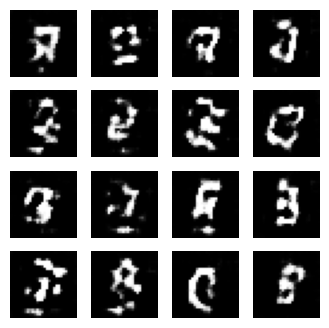

Time taken to process epoch 1 was 67.28784132003784 seconds


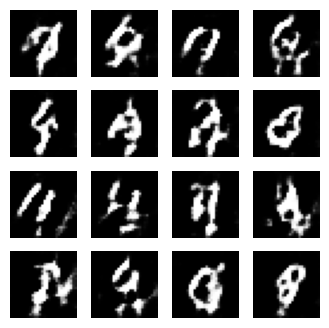

Time taken to process epoch 2 was 82.49409031867981 seconds


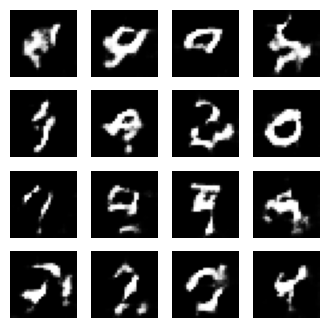

Time taken to process epoch 3 was 82.66324257850647 seconds


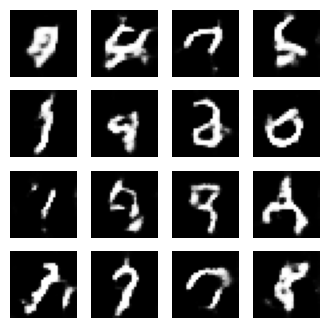

Time taken to process epoch 4 was 59.27823448181152 seconds


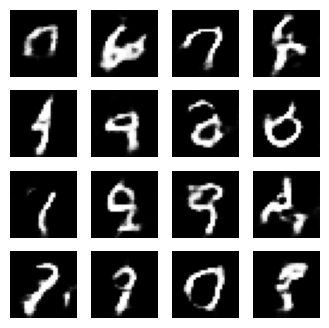

Time taken to process epoch 5 was 59.0659453868866 seconds


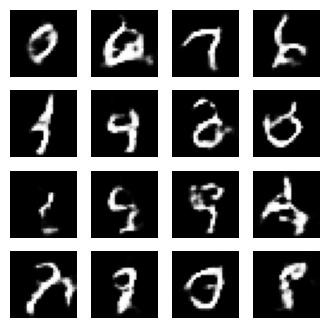

Time taken to process epoch 6 was 58.83804798126221 seconds


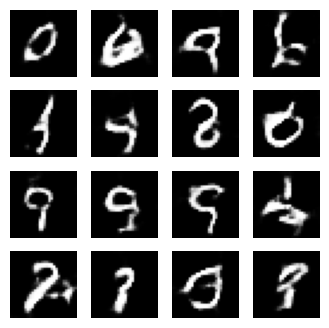

Time taken to process epoch 7 was 58.67642068862915 seconds


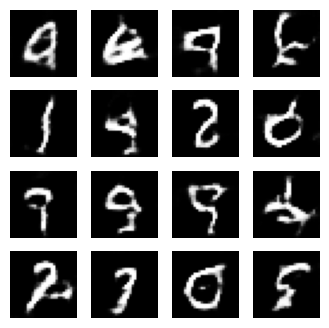

Time taken to process epoch 8 was 58.69941067695618 seconds


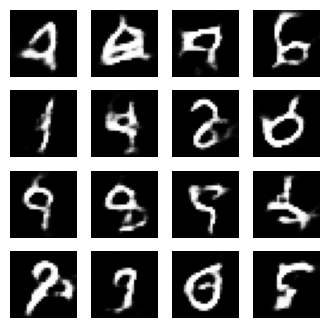

Time taken to process epoch 9 was 58.85184574127197 seconds


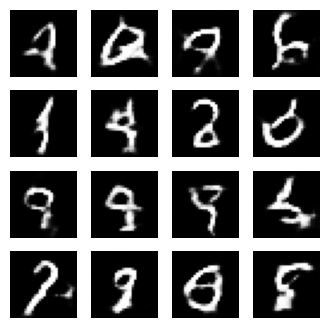

Time taken to process epoch 10 was 82.56202006340027 seconds


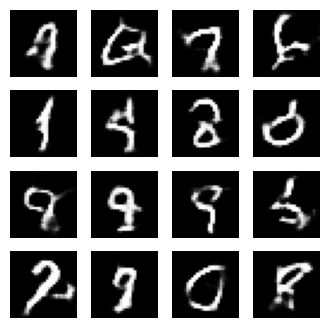

Time taken to process epoch 11 was 82.43310308456421 seconds


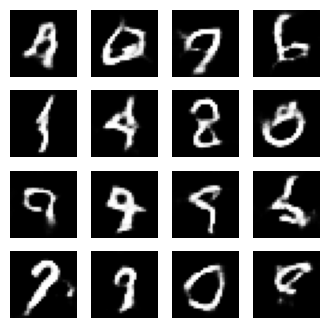

Time taken to process epoch 12 was 59.063748359680176 seconds


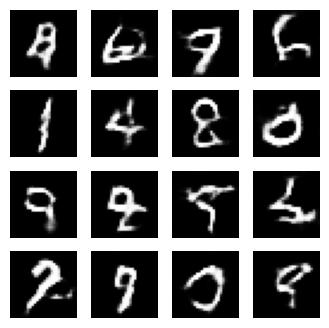

Time taken to process epoch 13 was 58.806522846221924 seconds


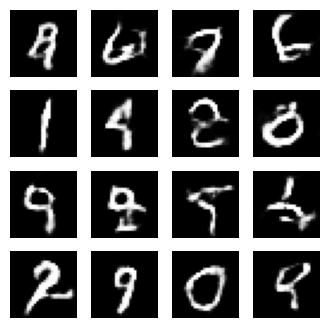

Time taken to process epoch 14 was 58.88299918174744 seconds


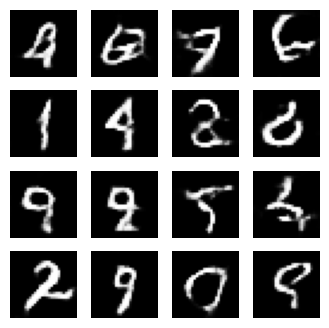

Time taken to process epoch 15 was 58.492517948150635 seconds


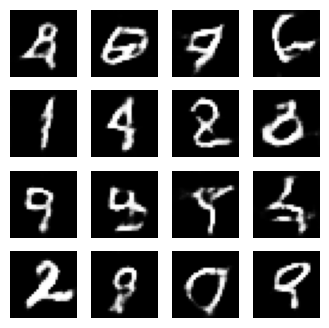

Time taken to process epoch 16 was 58.55937099456787 seconds


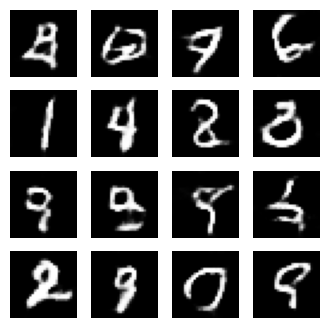

Time taken to process epoch 17 was 58.79824757575989 seconds


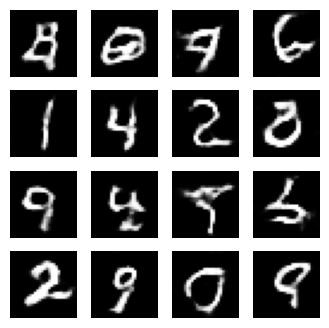

Time taken to process epoch 18 was 82.36627340316772 seconds


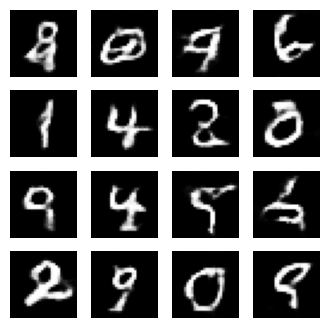

Time taken to process epoch 19 was 82.37260603904724 seconds


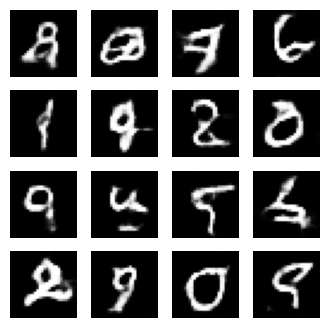

Time taken to process epoch 20 was 82.65068030357361 seconds


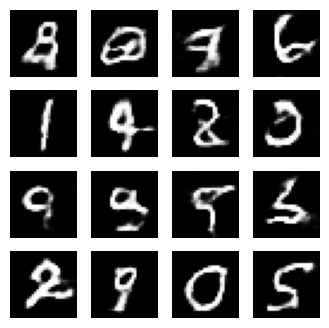

Time taken to process epoch 21 was 82.68444108963013 seconds


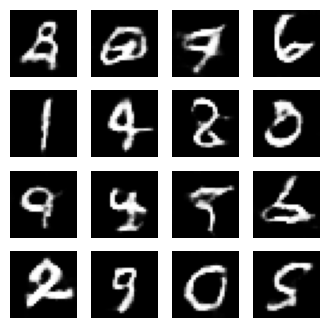

Time taken to process epoch 22 was 82.42700123786926 seconds


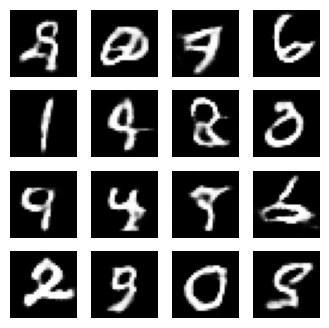

Time taken to process epoch 23 was 82.45379900932312 seconds


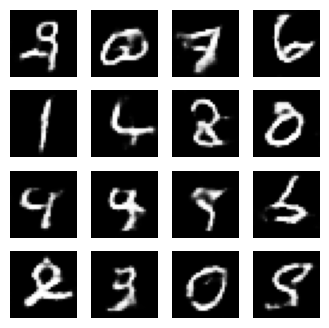

Time taken to process epoch 24 was 82.57157349586487 seconds


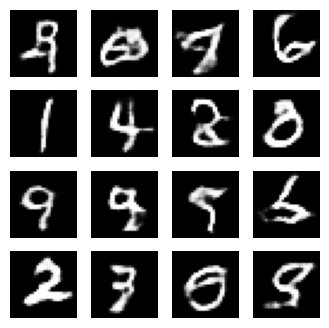

Time taken to process epoch 25 was 58.70026516914368 seconds


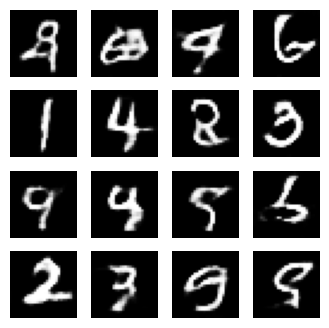

Time taken to process epoch 26 was 58.110451459884644 seconds


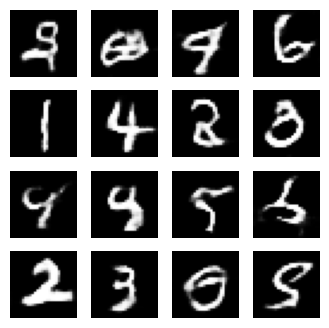

Time taken to process epoch 27 was 58.42481803894043 seconds


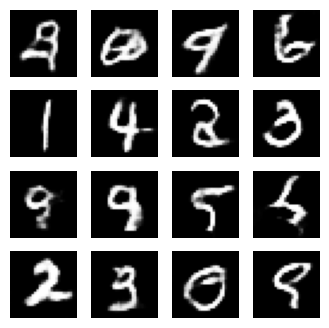

Time taken to process epoch 28 was 58.193960428237915 seconds


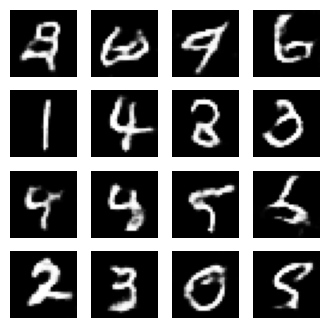

Time taken to process epoch 29 was 61.03543400764465 seconds


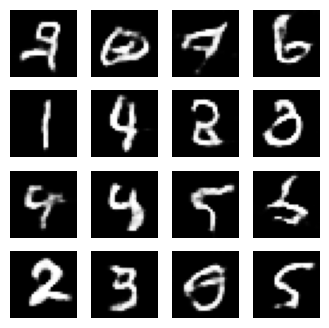

Time taken to process epoch 30 was 58.73556923866272 seconds


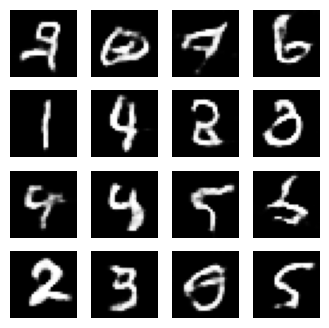

In [ ]:
train(X_train, epochs)

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

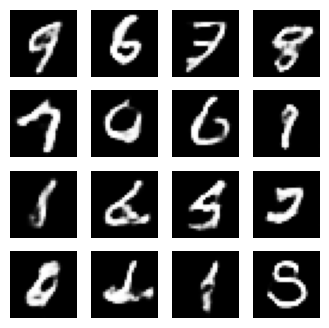

In [ ]:
seed_input = tf.random.normal([number_of_images, noise_dim])
preds = generator(seed_input, training = False)
fig = plt.figure(figsize = (4,4))
for i in range(preds.shape[0]):
  plt.subplot(4,4,i+1)
  plt.imshow(preds[i, :, :, 0] * 127.5 + 127.5, cmap = 'gray')
  plt.axis('off')

> More implementations:

* https://github.com/robbiebarrat/art-DCGAN (based on DCGAN)
* https://github.com/tdrussell/IllustrationGAN (based on DCGAN)
* https://github.com/viuts/wgan-animefaces (based on WGAN)